# Exercise: Geographical Cluster Analysis of Taxi Rides
Using the NY Taxi data set (see Use Case Block I) and the use case from the lecture...

In [160]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_samples, silhouette_score

In [5]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


In [6]:
# we load the data we have saved after wrangling and pre-processing in block I
train=pd.read_csv(path+'/DATA/train_cleaned.csv')

In [7]:
#select only the culumns with the ride coordinates
coordinates = train[ ['pickup_latitude','pickup_longitude','dropoff_latitude' , 'dropoff_longitude' ] ]

## Clustering approach from the lecture
we will be using simple K-Means:
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [8]:
from sklearn.cluster import KMeans

In [58]:
#define number of clusters and create instance
clusters=100
myKMeans=KMeans(n_clusters=clusters, n_jobs=-1)#parallelize to all cores

In [59]:
#train model
myKMeans.fit(coordinates.to_numpy()[:100000,:])#use only subset of the data to make it faster

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [60]:
#get cluster centers
centers=myKMeans.cluster_centers_
    

In [61]:
#draw map: green: start, red: end
cluster_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)
for i in range(clusters):
    folium.CircleMarker([centers[i,0], centers[i,1]], radius=3,                
                        color="green", 
                        fill_opacity=0.9
                       ).add_to(cluster_map)
    folium.CircleMarker([centers[i,2], centers[i,3]], radius=3,                
                        color="red", 
                        fill_opacity=0.9
                       ).add_to(cluster_map)
    folium.PolyLine([ [centers[i,0],centers[i,1]] , [centers[i,2],centers[i,3]]  ], color="black", weight=2.5, opacity=1).add_to(cluster_map)

In [13]:
cluster_map

## Exercise 1
Write a function ```show_cluster(cluster_number,...)``` that draws the cluster centers and all start and end points of a given cluster in the map.
* use the ```predict()``` method to map all data in ```train_data``` to a cluster center
* use ```folium.CircleMarker``` to draw all members of a given cluster


In [50]:
def show_cluster(data):
    myKMeans.fit(data)
    centers = myKMeans.cluster_centers_


    cluster_map = folium.Map(width=600, height=500 ,location = [40.730610, -73.935242], zoom_start = 12,)

    for i in range(clusters):
        folium.CircleMarker([centers[i,0], centers[i,1]], radius=3,
                            color="green",
                            fill_opacity=0.9
                           ).add_to(cluster_map)
        folium.CircleMarker([centers[i,2], centers[i,3]], radius=3,
                           color="red",
                           fill_opacity=0.9
                           ).add_to(cluster_map)
    display(cluster_map)
    
    
    

In [51]:
show_cluster(100, coordinates.to_numpy()[:100000,:])

## Exercise 2
Write a function ```cluster_var(cluster_number,...)``` that computes the intra- and extra cluster variance for a given cluster. Apply it to all clusters and compare the results for k=100 and k=10.

In [148]:
def cluster_var(nodes, centers):
    euclid = cdist(nodes,centers, 'euclidean')
    dist = np.min(euclid, axis=1)
    intra_var=np.mean(dist)
    print("Intra cluster var:", intra_var)
    
    extra_dist = cdist(centers,centers,'euclidean')
    extra_var = np.min(extra_dist[np.nonzero(extra_dist)])
    print("Extra cluster var:", extra_var)
    

In [149]:
clusters=100
nodes = coordinates.to_numpy()[:1000,:]
myKMeans=KMeans(n_clusters=clusters, n_jobs=-1)#parallelize to all cores    
myKMeans.fit(nodes)#use only subset of the data to make it faster
centers=myKMeans.cluster_centers_
print("Cluster variance 100 cluster center:")
cluster_var(nodes, centers)

clusters=10
myKMeans=KMeans(n_clusters=clusters, n_jobs=-1)#parallelize to all cores    
myKMeans.fit(nodes)#use only subset of the data to make it faster
centers=myKMeans.cluster_centers_
print("Cluster variance 10 cluster center:")
cluster_var(nodes, centers)



Cluster variance 10 cluster center:
Intra cluster var: 0.010727426056677068
Extra cluster var: 0.01270915464798542
Cluster variance 100 cluster center:
Intra cluster var: 0.02538829900263345
Extra cluster var: 0.03563657025537382


## Bonus Exercise:
Implement the Silhouette analysis copied from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_cluster = 10 The average silhouette_score is : 0.2710196652542401


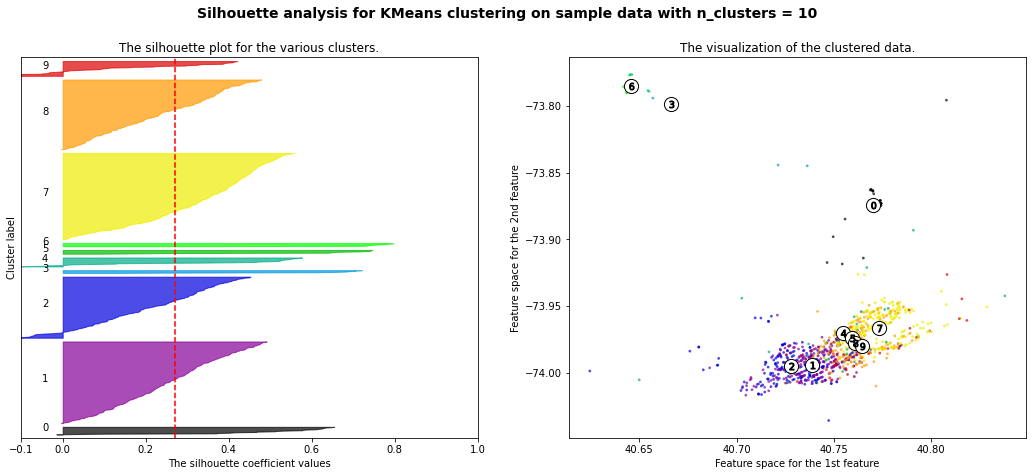

In [184]:
clusters=10
myKMeans=KMeans(n_clusters=clusters, n_jobs=-1)#parallelize to all cores    
myKMeans.fit(nodes)#use only subset of the data to make it faster
centers=myKMeans.cluster_centers_


silhouette_avg = silhouette_score(nodes, myKMeans.labels_)
print("For n_cluster =",clusters,
     "The average silhouette_score is :", silhouette_avg)
sample_silhouette_values = silhouette_samples(nodes, myKMeans.labels_)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(nodes) + (clusters + 1) * 10])


y_lower = 10
for i in range(clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[myKMeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(myKMeans.labels_.astype(float) / clusters)
ax2.scatter(nodes[:, 0], nodes[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % clusters),
             fontsize=14, fontweight='bold')

plt.show()
